In [1]:
import numpy as np
seed = 7
np.random.seed(seed)
import pandas as pd
from keras.layers import Input, Activation, Dense, Convolution2D, MaxPooling2D, Dropout, Flatten, merge
from keras.models import Model

Using TensorFlow backend.


In [2]:
####################
# Global Variables #
####################
nx = 25 # size of image in eta
ny = 25 # size of image in phi
xbins = np.linspace(-1.0,1.0,nx+1)
ybins = np.linspace(-1.0,1.0,ny+1)

In [3]:
input_layer = Input(shape=(nx,ny,1))
layer = Convolution2D(15, (9,9), padding='same')(input_layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(10, (7,7), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(3,3))(layer)
layer = Convolution2D(8, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = Convolution2D(6, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)
layer = MaxPooling2D(pool_size=(2,2))(layer)
layer = Convolution2D(4, (5,5), padding='same')(layer)
layer = Activation('tanh')(layer)

layer = Flatten()(layer)

# additional features input
jet_eta_ak7_input = Input(shape=(1,), name='jet_eta_ak7_input')
layer = merge([layer, jet_eta_ak7_input], mode='concat')
layer = Dense(20, activation='sigmoid')(layer)
layer = Dropout(0.08)(layer)
jet_pt_ak7_input = Input(shape=(1,), name='jet_pt_ak7_input')
layer = merge([layer, jet_pt_ak7_input], mode='concat')
layer = Dense(20, activation='softplus')(layer)
layer = Dropout(0.08)(layer)
output_layer = Dense(1, activation='linear', name='main_output')(layer)
model = Model(inputs=[input_layer,jet_pt_ak7_input,jet_eta_ak7_input], outputs=output_layer)

model.compile(optimizer='adam', loss='mse', metrics=['accuracy','mse','msle'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 25, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 25, 25, 15)   1230        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 25, 25, 15)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 12, 12, 15)   0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:20: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/site-packages/keras/legacy/layers.py:458: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)
/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:24: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.


In [4]:
df_dict_jets = pd.read_pickle('data/df_dict_jets.pkl')
jet_images = np.load('data/jet_images.npy')

In [5]:
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=20)
kfold = StratifiedKFold(n_splits=2, shuffle=True,  random_state=seed)
bs=256

In [6]:
history = model.fit([jet_images, df_dict_jets['jet_pt'], df_dict_jets['jet_eta']],  df_dict_jets['jet_jes'],
                    validation_data=([jet_images, df_dict_jets['jet_pt'], df_dict_jets['jet_eta']],  df_dict_jets['jet_jes']),
                    nb_epoch=400, batch_size=bs, verbose=1, callbacks=[early_stopping])

/usr/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  This is separate from the ipykernel package so we can avoid doing imports until


Train on 52992 samples, validate on 52992 samples
Epoch 1/400
52992/52992 [==============================] - 6s 115us/step - loss: 0.1031 - acc: 0.0000e+00 - mean_squared_error: 0.1031 - mean_squared_logarithmic_error: 0.0327 - val_loss: 0.0013 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0013 - val_mean_squared_logarithmic_error: 3.3082e-04
Epoch 2/400
52992/52992 [==============================] - 5s 96us/step - loss: 0.0396 - acc: 0.0000e+00 - mean_squared_error: 0.0396 - mean_squared_logarithmic_error: 0.0109 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0011 - val_mean_squared_logarithmic_error: 2.6923e-04
Epoch 3/400
52992/52992 [==============================] - 5s 96us/step - loss: 0.0266 - acc: 0.0000e+00 - mean_squared_error: 0.0266 - mean_squared_logarithmic_error: 0.0072 - val_loss: 0.0011 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.0011 - val_mean_squared_logarithmic_error: 2.7295e-04
Epoch 4/400
52992/52992 [==============================

Epoch 28/400
52992/52992 [==============================] - 5s 96us/step - loss: 0.0012 - acc: 0.0000e+00 - mean_squared_error: 0.0012 - mean_squared_logarithmic_error: 2.9680e-04 - val_loss: 9.2990e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 9.2990e-04 - val_mean_squared_logarithmic_error: 2.3185e-04
Epoch 29/400
52992/52992 [==============================] - 5s 96us/step - loss: 0.0011 - acc: 0.0000e+00 - mean_squared_error: 0.0011 - mean_squared_logarithmic_error: 2.8420e-04 - val_loss: 9.2905e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 9.2905e-04 - val_mean_squared_logarithmic_error: 2.3194e-04
Epoch 30/400
52992/52992 [==============================] - 5s 96us/step - loss: 0.0011 - acc: 0.0000e+00 - mean_squared_error: 0.0011 - mean_squared_logarithmic_error: 2.7223e-04 - val_loss: 9.2890e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 9.2890e-04 - val_mean_squared_logarithmic_error: 2.3174e-04
Epoch 31/400
52992/52992 [==============================] - 5s 96us

Epoch 54/400
52992/52992 [==============================] - 5s 96us/step - loss: 7.9696e-04 - acc: 0.0000e+00 - mean_squared_error: 7.9696e-04 - mean_squared_logarithmic_error: 1.9860e-04 - val_loss: 8.2675e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 8.2675e-04 - val_mean_squared_logarithmic_error: 2.0682e-04
Epoch 55/400
52992/52992 [==============================] - 5s 95us/step - loss: 7.9106e-04 - acc: 0.0000e+00 - mean_squared_error: 7.9106e-04 - mean_squared_logarithmic_error: 1.9714e-04 - val_loss: 7.5578e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 7.5578e-04 - val_mean_squared_logarithmic_error: 1.8807e-04
Epoch 56/400
52992/52992 [==============================] - 5s 96us/step - loss: 7.7901e-04 - acc: 0.0000e+00 - mean_squared_error: 7.7901e-04 - mean_squared_logarithmic_error: 1.9407e-04 - val_loss: 7.3842e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 7.3842e-04 - val_mean_squared_logarithmic_error: 1.8397e-04
Epoch 57/400
52992/52992 [=================

Epoch 80/400
52992/52992 [==============================] - 5s 96us/step - loss: 5.8251e-04 - acc: 0.0000e+00 - mean_squared_error: 5.8251e-04 - mean_squared_logarithmic_error: 1.4463e-04 - val_loss: 5.2738e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 5.2738e-04 - val_mean_squared_logarithmic_error: 1.3077e-04
Epoch 81/400
52992/52992 [==============================] - 5s 96us/step - loss: 5.8173e-04 - acc: 0.0000e+00 - mean_squared_error: 5.8173e-04 - mean_squared_logarithmic_error: 1.4444e-04 - val_loss: 5.2082e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 5.2082e-04 - val_mean_squared_logarithmic_error: 1.2926e-04
Epoch 82/400
52992/52992 [==============================] - 5s 96us/step - loss: 5.7420e-04 - acc: 0.0000e+00 - mean_squared_error: 5.7420e-04 - mean_squared_logarithmic_error: 1.4259e-04 - val_loss: 5.1603e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 5.1603e-04 - val_mean_squared_logarithmic_error: 1.2787e-04
Epoch 83/400
52992/52992 [=================

Epoch 106/400
52992/52992 [==============================] - 5s 96us/step - loss: 4.8517e-04 - acc: 0.0000e+00 - mean_squared_error: 4.8517e-04 - mean_squared_logarithmic_error: 1.2023e-04 - val_loss: 4.4544e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 4.4544e-04 - val_mean_squared_logarithmic_error: 1.1062e-04
Epoch 107/400
52992/52992 [==============================] - 5s 95us/step - loss: 4.8228e-04 - acc: 0.0000e+00 - mean_squared_error: 4.8228e-04 - mean_squared_logarithmic_error: 1.1950e-04 - val_loss: 4.5316e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 4.5316e-04 - val_mean_squared_logarithmic_error: 1.1260e-04
Epoch 108/400
52992/52992 [==============================] - 5s 96us/step - loss: 4.7811e-04 - acc: 0.0000e+00 - mean_squared_error: 4.7811e-04 - mean_squared_logarithmic_error: 1.1847e-04 - val_loss: 4.1607e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 4.1607e-04 - val_mean_squared_logarithmic_error: 1.0300e-04
Epoch 109/400
52992/52992 [=============

Epoch 132/400
52992/52992 [==============================] - 5s 96us/step - loss: 4.1879e-04 - acc: 0.0000e+00 - mean_squared_error: 4.1879e-04 - mean_squared_logarithmic_error: 1.0372e-04 - val_loss: 3.7338e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.7338e-04 - val_mean_squared_logarithmic_error: 9.2270e-05
Epoch 133/400
52992/52992 [==============================] - 5s 96us/step - loss: 4.2470e-04 - acc: 0.0000e+00 - mean_squared_error: 4.2470e-04 - mean_squared_logarithmic_error: 1.0518e-04 - val_loss: 3.7200e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.7200e-04 - val_mean_squared_logarithmic_error: 9.2033e-05
Epoch 134/400
52992/52992 [==============================] - 5s 96us/step - loss: 4.1471e-04 - acc: 0.0000e+00 - mean_squared_error: 4.1471e-04 - mean_squared_logarithmic_error: 1.0271e-04 - val_loss: 3.7640e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.7640e-04 - val_mean_squared_logarithmic_error: 9.3074e-05
Epoch 135/400
52992/52992 [=============

Epoch 158/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.8527e-04 - acc: 0.0000e+00 - mean_squared_error: 3.8527e-04 - mean_squared_logarithmic_error: 9.5404e-05 - val_loss: 3.4437e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.4437e-04 - val_mean_squared_logarithmic_error: 8.5221e-05
Epoch 159/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.8574e-04 - acc: 0.0000e+00 - mean_squared_error: 3.8574e-04 - mean_squared_logarithmic_error: 9.5498e-05 - val_loss: 3.5012e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.5012e-04 - val_mean_squared_logarithmic_error: 8.6525e-05
Epoch 160/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.8495e-04 - acc: 0.0000e+00 - mean_squared_error: 3.8495e-04 - mean_squared_logarithmic_error: 9.5335e-05 - val_loss: 3.5708e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.5708e-04 - val_mean_squared_logarithmic_error: 8.8522e-05
Epoch 161/400
52992/52992 [=============

Epoch 184/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.6487e-04 - acc: 0.0000e+00 - mean_squared_error: 3.6487e-04 - mean_squared_logarithmic_error: 9.0373e-05 - val_loss: 3.2758e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.2758e-04 - val_mean_squared_logarithmic_error: 8.1138e-05
Epoch 185/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.6699e-04 - acc: 0.0000e+00 - mean_squared_error: 3.6699e-04 - mean_squared_logarithmic_error: 9.0884e-05 - val_loss: 3.1976e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.1976e-04 - val_mean_squared_logarithmic_error: 7.9004e-05
Epoch 186/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.5874e-04 - acc: 0.0000e+00 - mean_squared_error: 3.5874e-04 - mean_squared_logarithmic_error: 8.8794e-05 - val_loss: 3.2829e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.2829e-04 - val_mean_squared_logarithmic_error: 8.1067e-05
Epoch 187/400
52992/52992 [=============

Epoch 210/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.4582e-04 - acc: 0.0000e+00 - mean_squared_error: 3.4582e-04 - mean_squared_logarithmic_error: 8.5635e-05 - val_loss: 3.0928e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.0928e-04 - val_mean_squared_logarithmic_error: 7.6497e-05
Epoch 211/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.4288e-04 - acc: 0.0000e+00 - mean_squared_error: 3.4288e-04 - mean_squared_logarithmic_error: 8.4899e-05 - val_loss: 3.0209e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.0209e-04 - val_mean_squared_logarithmic_error: 7.4628e-05
Epoch 212/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.4443e-04 - acc: 0.0000e+00 - mean_squared_error: 3.4443e-04 - mean_squared_logarithmic_error: 8.5286e-05 - val_loss: 3.0562e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 3.0562e-04 - val_mean_squared_logarithmic_error: 7.5549e-05
Epoch 213/400
52992/52992 [=============

Epoch 236/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.3082e-04 - acc: 0.0000e+00 - mean_squared_error: 3.3082e-04 - mean_squared_logarithmic_error: 8.1921e-05 - val_loss: 2.9072e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.9072e-04 - val_mean_squared_logarithmic_error: 7.1863e-05
Epoch 237/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.3193e-04 - acc: 0.0000e+00 - mean_squared_error: 3.3193e-04 - mean_squared_logarithmic_error: 8.2214e-05 - val_loss: 2.8899e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.8899e-04 - val_mean_squared_logarithmic_error: 7.1418e-05
Epoch 238/400
52992/52992 [==============================] - 5s 97us/step - loss: 3.3382e-04 - acc: 0.0000e+00 - mean_squared_error: 3.3382e-04 - mean_squared_logarithmic_error: 8.2660e-05 - val_loss: 2.9763e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.9763e-04 - val_mean_squared_logarithmic_error: 7.3689e-05
Epoch 239/400
52992/52992 [=============

Epoch 262/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.2267e-04 - acc: 0.0000e+00 - mean_squared_error: 3.2267e-04 - mean_squared_logarithmic_error: 7.9928e-05 - val_loss: 2.8565e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.8565e-04 - val_mean_squared_logarithmic_error: 7.0632e-05
Epoch 263/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.1550e-04 - acc: 0.0000e+00 - mean_squared_error: 3.1550e-04 - mean_squared_logarithmic_error: 7.8109e-05 - val_loss: 2.7631e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.7631e-04 - val_mean_squared_logarithmic_error: 6.8288e-05
Epoch 264/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.2058e-04 - acc: 0.0000e+00 - mean_squared_error: 3.2058e-04 - mean_squared_logarithmic_error: 7.9398e-05 - val_loss: 2.7944e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.7944e-04 - val_mean_squared_logarithmic_error: 6.9147e-05
Epoch 265/400
52992/52992 [=============

Epoch 288/400
52992/52992 [==============================] - 5s 97us/step - loss: 3.0872e-04 - acc: 0.0000e+00 - mean_squared_error: 3.0872e-04 - mean_squared_logarithmic_error: 7.6431e-05 - val_loss: 2.7889e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.7889e-04 - val_mean_squared_logarithmic_error: 6.9063e-05
Epoch 289/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.0739e-04 - acc: 0.0000e+00 - mean_squared_error: 3.0739e-04 - mean_squared_logarithmic_error: 7.6135e-05 - val_loss: 2.7296e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.7296e-04 - val_mean_squared_logarithmic_error: 6.7504e-05
Epoch 290/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.1227e-04 - acc: 0.0000e+00 - mean_squared_error: 3.1227e-04 - mean_squared_logarithmic_error: 7.7351e-05 - val_loss: 2.8552e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.8552e-04 - val_mean_squared_logarithmic_error: 7.0696e-05
Epoch 291/400
52992/52992 [=============

Epoch 314/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.0156e-04 - acc: 0.0000e+00 - mean_squared_error: 3.0156e-04 - mean_squared_logarithmic_error: 7.4656e-05 - val_loss: 2.6457e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.6457e-04 - val_mean_squared_logarithmic_error: 6.5411e-05
Epoch 315/400
52992/52992 [==============================] - 5s 97us/step - loss: 3.0204e-04 - acc: 0.0000e+00 - mean_squared_error: 3.0204e-04 - mean_squared_logarithmic_error: 7.4787e-05 - val_loss: 2.6882e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.6882e-04 - val_mean_squared_logarithmic_error: 6.6361e-05
Epoch 316/400
52992/52992 [==============================] - 5s 96us/step - loss: 3.0176e-04 - acc: 0.0000e+00 - mean_squared_error: 3.0176e-04 - mean_squared_logarithmic_error: 7.4738e-05 - val_loss: 2.8225e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.8225e-04 - val_mean_squared_logarithmic_error: 7.0031e-05
Epoch 317/400
52992/52992 [=============

Epoch 340/400
52992/52992 [==============================] - 5s 96us/step - loss: 2.9778e-04 - acc: 0.0000e+00 - mean_squared_error: 2.9778e-04 - mean_squared_logarithmic_error: 7.3734e-05 - val_loss: 2.5878e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.5878e-04 - val_mean_squared_logarithmic_error: 6.3889e-05
Epoch 341/400
52992/52992 [==============================] - 5s 96us/step - loss: 2.9636e-04 - acc: 0.0000e+00 - mean_squared_error: 2.9636e-04 - mean_squared_logarithmic_error: 7.3374e-05 - val_loss: 2.6060e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.6060e-04 - val_mean_squared_logarithmic_error: 6.4515e-05
Epoch 342/400
52992/52992 [==============================] - 5s 96us/step - loss: 2.9906e-04 - acc: 0.0000e+00 - mean_squared_error: 2.9906e-04 - mean_squared_logarithmic_error: 7.4057e-05 - val_loss: 2.6037e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.6037e-04 - val_mean_squared_logarithmic_error: 6.4378e-05
Epoch 343/400
52992/52992 [=============

Epoch 366/400
52992/52992 [==============================] - 5s 96us/step - loss: 2.9160e-04 - acc: 0.0000e+00 - mean_squared_error: 2.9160e-04 - mean_squared_logarithmic_error: 7.2212e-05 - val_loss: 2.6035e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.6035e-04 - val_mean_squared_logarithmic_error: 6.4322e-05
Epoch 367/400
52992/52992 [==============================] - 5s 96us/step - loss: 2.9107e-04 - acc: 0.0000e+00 - mean_squared_error: 2.9107e-04 - mean_squared_logarithmic_error: 7.2071e-05 - val_loss: 2.6678e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.6678e-04 - val_mean_squared_logarithmic_error: 6.6015e-05
Epoch 368/400
52992/52992 [==============================] - 5s 96us/step - loss: 2.9202e-04 - acc: 0.0000e+00 - mean_squared_error: 2.9202e-04 - mean_squared_logarithmic_error: 7.2324e-05 - val_loss: 2.5859e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.5859e-04 - val_mean_squared_logarithmic_error: 6.3938e-05
Epoch 369/400
52992/52992 [=============

Epoch 392/400
52992/52992 [==============================] - 5s 96us/step - loss: 2.8880e-04 - acc: 0.0000e+00 - mean_squared_error: 2.8880e-04 - mean_squared_logarithmic_error: 7.1499e-05 - val_loss: 2.5661e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.5661e-04 - val_mean_squared_logarithmic_error: 6.3561e-05
Epoch 393/400
52992/52992 [==============================] - 5s 96us/step - loss: 2.8489e-04 - acc: 0.0000e+00 - mean_squared_error: 2.8489e-04 - mean_squared_logarithmic_error: 7.0508e-05 - val_loss: 2.5138e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.5138e-04 - val_mean_squared_logarithmic_error: 6.2154e-05
Epoch 394/400
52992/52992 [==============================] - 5s 96us/step - loss: 2.8846e-04 - acc: 0.0000e+00 - mean_squared_error: 2.8846e-04 - mean_squared_logarithmic_error: 7.1427e-05 - val_loss: 2.6651e-04 - val_acc: 0.0000e+00 - val_mean_squared_error: 2.6651e-04 - val_mean_squared_logarithmic_error: 6.5800e-05
Epoch 395/400
52992/52992 [=============

In [7]:
model.save('models/DeepJEC.h5')

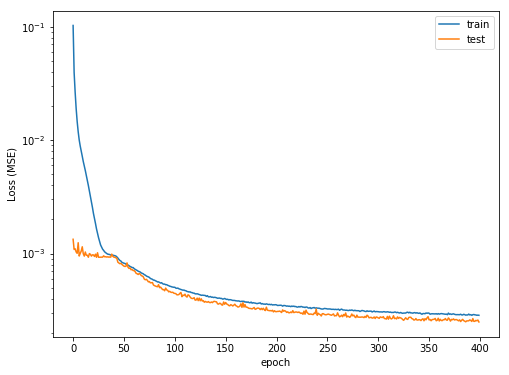

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,6))

loss = np.asarray(history.history['loss'])
val_loss = np.asarray(history.history['val_loss'])
plt.plot(loss, label='train')
plt.plot(val_loss, label='test')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Loss (MSE)')
plt.yscale('log')

plt.savefig('plots/train_val_loss.pdf')